In [2]:
!pip install ale-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.9 MB/s eta 0:00:0000:0100:01


In [10]:
!pip install torchsummary

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 512]       1,606,144
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 6]           3,078
Total params: 1,687,206
Trainable params: 1,687,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.33
Params size (MB): 6.44
Estimated Total Size (MB): 6.87
--------------------

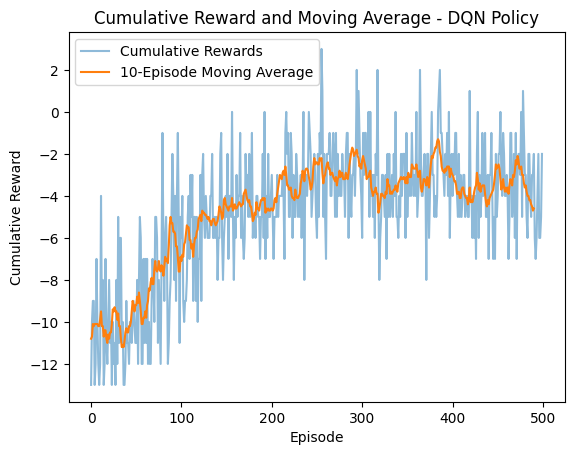

Results saved to dqn_policy_results.json


In [12]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json
import cv2
from ale_py import ALEInterface
ale = ALEInterface()

# Initialize environment
env = gym.make("ALE/Pong-v5", render_mode=None)  # Disable rendering for training
env.reset(seed=42)

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Preprocessing function
def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    resized_frame = cv2.resize(gray_frame, (84, 84))  # Resize to 84x84
    normalized_frame = resized_frame / 255.0  # Normalize pixel values
    return normalized_frame

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), # Flatten the output for fully connected network (convert 3D tensor to 1D tensor)
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Hyperparameters
num_episodes = 500 # Episodes to train 
max_iter = 500 # Make sure agent has enough time to play full game
batch_size = 32
gamma = 0.99
lr = 1e-4
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.99 # faster decay before it was 0.995
replay_buffer_size = 10000
target_update_freq = 5

# Initialize model, optimizer, and replay buffer
input_shape = (4, 84, 84) # Input shape for stacked Pong frames
num_actions = env.action_space.n
policy_net = DQN(input_shape, num_actions).float().to(device)
target_net = DQN(input_shape, num_actions).float().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = deque(maxlen=replay_buffer_size)

# Print model summary
torchsummary.summary(policy_net, input_size=(4, 84, 84))


def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            # Move state_tensor to the correct device
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            return policy_net(state_tensor).argmax().item()

def optimize_model():
    if len(replay_buffer) < batch_size:
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
epsilon = epsilon_start
cumulative_rewards_dqn = []

for episode in range(num_episodes):
    if episode % 50 == 0 and episode > 0:  # Save model every 50 episodes; before 100
        model_save_path = f"policy_net_episode_{episode}.pth"
        torch.save(policy_net.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
    state, _ = env.reset()
    state = preprocess_frame(state)
    state_stack = np.stack([state] * 4, axis=0)  # Initial stack of frames
    episode_reward = 0

    for t in range(max_iter):
        action = select_action(state_stack, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state_stack = np.concatenate((state_stack[1:], np.expand_dims(next_state, axis=0)), axis=0)

        replay_buffer.append((state_stack, action, reward, next_state_stack, terminated or truncated))

        state_stack = next_state_stack
        episode_reward += reward

        optimize_model()
        
        if terminated or truncated:
            break

    cumulative_rewards_dqn.append(episode_reward)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode + 1}: Reward = {episode_reward}")

env.close()

# Analyze DQN performance
# Calculate moving average of cumulative rewards
window_size = 10  # Every 10 episodes
moving_avg = np.convolve(cumulative_rewards_dqn, np.ones(window_size) / window_size, mode='valid')

# Calculate win rate for DQN policy
wins = sum(1 for reward in cumulative_rewards_dqn if reward > 0)
win_rate = wins / num_episodes * 100

# Plot cumulative rewards and moving average
plt.plot(cumulative_rewards_dqn, label="Cumulative Rewards", alpha=0.5)
plt.plot(range(len(moving_avg)), moving_avg, label=f"{window_size}-Episode Moving Average")
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward and Moving Average - DQN Policy')
plt.legend()
plt.savefig("dqn_cumulative_rewards.jpg", format="jpg", dpi=300)
plt.show()

# Average cumulative reward
average_cumulative_reward = sum(cumulative_rewards_dqn) / num_episodes

# Save results as JSON
dqn_policy_results = {
    "policy": "DQN",
    "num_episodes": num_episodes,
    "cumulative_rewards": cumulative_rewards_dqn,
    "average_reward": average_cumulative_reward,
    "win_rate": win_rate,
    "moving_average": moving_avg.tolist()
}

save_path = 'dqn_policy_results.json'

# Save the data to a JSON file for later analysis
with open(save_path, "w") as f:
    json.dump(dqn_policy_results, f, indent=4)
print(f"Results saved to {save_path}")